# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
    - The client is interested to predict whether a cherry leaf is healthy or contains powdery mildew. 

## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Cherry Leave Images distribution plot in train, validation, and test dataset.

## Additional Comments

---

## Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\All\\Desktop\\Zoe_Deve\\ML-Mildew-Detector-\\jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\All\\Desktop\\Zoe_Deve\\ML-Mildew-Detector-'

### Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

### Set input directories for train, validation and test paths

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1-mildew'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print('Class Labels are', labels)

Class Labels are ['healthy', 'powdery_mildew']


### Set image shape

In [8]:
## Import image shape embedding saved at repo
version = 'v1-mildew'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Plot number of images in train, test and validation dataset

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




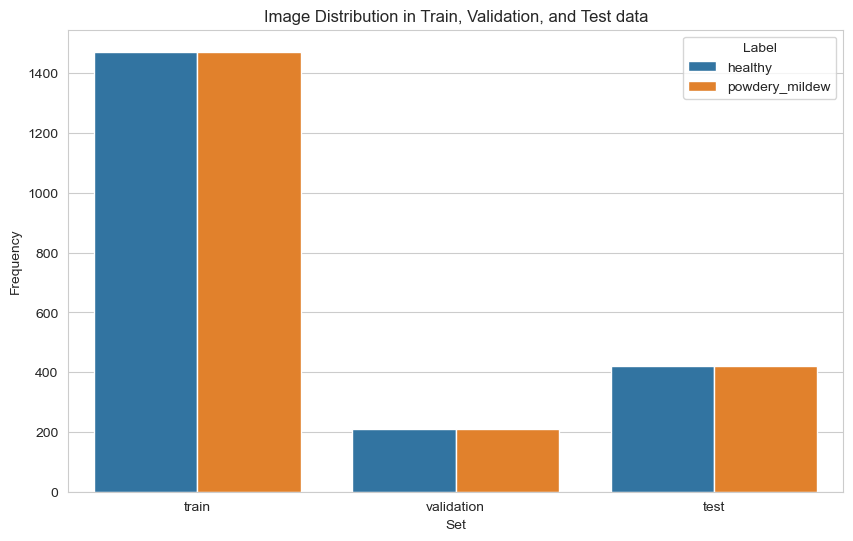

In [9]:
import glob

data_dirs = ['train', 'validation', 'test']

df_freq = pd.DataFrame([])

for folder in data_dirs:
    for label in os.listdir(os.path.join(my_data_dir, folder)):
        image_count = len(os.listdir(os.path.join(my_data_dir, folder, label)))
        df_freq = df_freq.append(pd.Series(data={'Set': folder, 'Label': label, 'Frequency': image_count}), ignore_index=True)
        print(f"* {folder} - {label}: {image_count} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution in Train, Validation, and Test data")
plt.xlabel("Set")
plt.ylabel("Frequency")
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

----

## Image data augmentation

### Import and Initialize ImageDataGenerator

Generate augmented images to produce variations of the original images for training the deep learning model, thereby enhancing its ability to handle a wider range of real-world scenarios.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xd

ImportError: initialization failed

### Augment training image dataset

In [ ]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

### Augment validation image dataset

In [ ]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

### Augment test image dataset

In [ ]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

## Plot augmented image in training set

In [ ]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Plot augmented images in validation and test sets

In [ ]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

In [ ]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [ ]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

---

## Model creation

### Machine Learning Model

* Import model package and create model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

def create_tf_model():
    model = Sequential()

    # Add Convolutional and Pooling Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    # Add Fully Connected Layers
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())  # Batch normalization for better training stability
    model.add(Dropout(0.5))  # Dropout for regularization
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


* Model Summary

In [ ]:
create_tf_model().summary()